### Import Needed Libraries and Files
Depending on what model we're using we have to check that the files are for that model

In [2]:
import numpy as np
import path as Path
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.axes as ax
from matplotlib.pyplot import figure
from IPython.display import Image
from astropy.io import fits
from astropy.table import Table
from astropy.cosmology import FlatwCDM
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import LambdaCDM
from astropy.cosmology import wCDM
from astropy.cosmology import Flatw0waCDM
import scipy
import pdb
from escape_functions_noastropy import *
from scipy.interpolate import interp1d
from scipy.stats import linregress

In [3]:
cosmo = FlatwCDM(H0=70, Om0=0.2,w0=-1)
cosmo = wCDM(H0=70, Om0=0.2,Ode0 = 0.8,w0=-1)
cosmo = FlatLambdaCDM(H0=70,Om0=0.2)
cosmo = LambdaCDM(H0=70, Om0=0.2, Ode0 = 0)
cosmo = Flatw0waCDM(H0=70, Om0=0.2, w0=-0.9, wa=0.2)

In [4]:
def cosmology(cosmology):
    case = cosmology.name
    if case == 'Flatw0waCDM':
        return [cosmology.Om0, cosmology.w0, cosmology.wa, cosmology.h]
    
    elif case == 'FlatwCDM':
        return [cosmology.Om0, cosmology.w0, cosmology.h]

    elif case == 'wCDM':
        return [cosmology.Om0, cosmology.Ode0, cosmology.w0,cosmology.h]
        
    elif case == 'LambdaCDM':
        return [cosmology.Om0, cosmology.Ode0, cosmology.h]

    elif case == 'FlatLambdaCDM':
        return [cosmology.Om0, cosmology.h]

Now set up reading in important files

In [5]:
front_part = '/nfs/Christoq1/pvans/MiraTitan/halo/sort/M000/halopart/'
front_halo = '/nfs/Christoq1/pvans/MiraTitan/FOF/M000_good/'
front_results = '/nfs/Christoq1/MiraTitanU_analysis/density_fits/results_pvans_M0/'

In [6]:
rad_file_0 = fits.open(front_results + 'phi_ein/r_vescmax.fits')
rad_0 = rad_file_0[0].data
m_edge_file_0 = fits.open(front_results + 'phi_ein/v_at_vescmax5.fits')
m_edge_0 = m_edge_file_0[0].data
dens_fit = fits.open(front_results + 'dens_ein/dens_fit.fits')
dt = [('HaloId',int), ('n',float), ('n_err',float),('rho_0',float),('rho_o_err',float),
          ('h',float),('h_err',float),('norm_ein',float)]
einasto_prof_0 =  np.loadtxt(front_results + 'dens_ein/ds_ein_concentrations.dat', dtype=dt,skiprows=0) 

In [7]:
rad_file_0_gam = fits.open(front_results + 'phi_gam/r_vescmax.fits')
rad_0_gam = rad_file_0_gam[0].data
m_edge_file_0_gam = fits.open(front_results + 'phi_gam/v_at_vescmax5.fits')
m_edge_0_gam = m_edge_file_0_gam[0].data
dens_fit_gam = fits.open(front_results + 'dens_gam/dens_fit.fits')
dt2 = [('HaloId', int),('gamma',float),('gamma_err',float),('mass0',float),('mass0_err',float),('r_s',float),('rs_err',float)]
dehnen_prof_0 =  np.loadtxt(front_results + 'dens_gam/ds_gam_concentrations.dat', dtype=dt2,skiprows=0) 

In [8]:
print (len(rad_0))

251


In [9]:
dt = [('HaloId', np.float64),('m200crit',np.float64),('px',float),('py',float),('pz',float),('vx',float),('vy',float),('vz',float)]
filename_0 =  front_halo + 'z00_good.txt'
filename_0e =  front_halo + 'z00_extras.txt'
cluster_list_0 =  np.loadtxt(filename_0, dtype=dt,skiprows=0)
cluster_list_0_e = np.loadtxt(filename_0e, dtype=dt,skiprows=0)
print (len(cluster_list_0))

#filename = '135284001.0part.fits' 
#local_filename = front_part + filename
#particles = fits.getdata(local_filename)

251


### Start with setting up cosmology, each model is different
#### M000
Use a cosmology with H0 = 71, Om0 = 0.2314, w0 = -1, wa = 0

#### M001
Use Flatw0waCDM with H0 = 61.67, Om0 = 0.3362, w0 = -0.7, wa = 0.6722



### M000

In [10]:
cosmo_name = 'FlatLambdaCDM'
cosmo = FlatLambdaCDM(H0=71,Om0=0.26479, name = cosmo_name)
cosmo_params = cosmology(cosmo)

In [11]:
z=0.0001
h_0 = 0.71
#mass = np.hstack((cluster_list_0['m200crit'], cluster_list_0_e['m200crit']))
mass = cluster_list_0['m200crit']
hmass = mass/h_0
#print (hmass)
M200 = hmass*u.solMass
rho_crit = cosmo.critical_density(z)
rho_crit = rho_crit.to(u.solMass / u.Mpc**3)
print ('Astropys critical density: ', rho_crit)
print ('Internal critical density: ',rho_crit_z(z,cosmo_params,'FlatLambdaCDM'))
R200crit =  (3*M200/(4*np.pi*200.* rho_crit))**(1./3.)
radius_array = np.linspace(0.3,2.0,100).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.
theta_array = radius_array /cosmo.angular_diameter_distance(z)
R200crit =  (3*M200/(4*np.pi*200.* rho_crit))**(1./3.)
#print ('Spherical R200 for a given M200: ', R200crit)
G_newton = astroc.G.to( u.Mpc *  u.km**2 / u.s**2 / u.solMass).value #Mpc km2/s^2 kg
#print ('Gravity (Mpc km2/s^2 kg), mass, cosmology: ', G_newton, M200, cosmo_params, cosmo.name)
#print ('q = ', q_z_function(z, cosmo_params,cosmo.name))
#print ('r_eq = ', r_eq(0.2,M200_orig,cosmo_params, cosmo.name))

Astropys critical density:  139917328634.8423 solMass / Mpc3
Internal critical density:  139917328634.8423 solMass / Mpc3


In [24]:
z_0 = np.array((0.0001))
z_0 = np.repeat(z_0,(251))
num_clus = len(z_0)
M200_orig = np.repeat(hmass,len(z_0))
M200_use = np.repeat(hmass,(1))
R200 =  ((3*M200)/(4*np.pi*200.* rho_crit))**(1./3.)
N = np.repeat(1000000,len(z_0))

rho_0_list = einasto_prof_0['rho_0']
h_list = einasto_prof_0['h']
n_list = einasto_prof_0['n']
rho_0 = np.repeat(rho_0_list, (1))
h = np.repeat(h_list, (1))
n = np.repeat(n_list, (1))

gamma_list = dehnen_prof_0['gamma']
mass0_list = dehnen_prof_0['mass0']
r_s_list = dehnen_prof_0['r_s']
gamma = np.repeat(gamma_list, (1))
mass_0 = np.repeat(mass0_list, (1))
r_s = np.repeat(r_s_list, (1))

radius_array = rad_0_gam #specify radius array for profiles. used in v_esc(r) funcs below.
#print (len(rad_0_gam))
radial_bins = 80
xdata = np.zeros((len(z_0),radial_bins))
for i in range(len(z_0)):
    #print (radius_array[i,:])
    xdata[i,:] = radius_array[i,:] /D_A(z_0[i], cosmo_params, cosmo.name).value
    #print (xdata[i,:])
r_M0_DEH,vesc_M0_DEH = v_esc_dehnen(xdata,z_0,mass_0,r_s,gamma,N, cosmo_params, cosmo_name, num_clus)
r_M0_EIN,vesc_M0_EIN = v_esc_einasto(xdata,z_0,rho_0,h,n,N, cosmo_params, cosmo_name, num_clus)
r_M0_NFW,vesc_M0_NFW = v_esc_NFW_M200(xdata,z_0,M200_use,N, cosmo_params, cosmo_name, num_clus)

In [25]:
print (min(mass))

401223026999296.0


In [26]:
print(r_M0_DEH[0],vesc_M0_DEH[0])

[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95 1.05 1.15 1.25 1.35
 1.45 1.55 1.65 1.75 1.85 1.95 2.05 2.15 2.25 2.35 2.45 2.55 2.65 2.75
 2.85 2.95 3.05 3.15 3.25 3.35 3.45 3.55 3.65 3.75 3.85 3.95 4.05 4.15
 4.25 4.35 4.45 4.55 4.65 4.75 4.85 4.95 5.05 5.15 5.25 5.35 5.45 5.55
 5.65 5.75 5.85 5.95 6.05 6.15 6.25 6.35 6.45 6.55 6.65 6.75 6.85 6.95
 7.05 7.15 7.25 7.35 7.45 7.55 7.65 7.75 7.85 7.95] [3549.3692762  3494.48411815 3418.79793389 3334.7874333  3248.30830299
 3162.33009007 3078.38519275 2997.24179151 2919.24607768 2844.50667241
 2772.99807456 2704.62035274 2639.23424903 2576.68204106 2516.79995946
 2459.42550806 2404.40166857 2351.57918644 2300.81767312 2251.98598184
 2204.96214427 2159.63304919 2115.89397847 2073.64807256 2032.80577116
 1993.28425686 1955.00691855 1917.90284385 1881.90634528 1846.95652199
 1812.99685674 1779.97484707 1747.84166862 1716.55186851 1686.0630864
 1656.33580092 1627.33309918 1599.02046735 1571.36560021 1544.33822797
 1517.90995863 1492.054134

Largest Halo Mass =  3718331262935617.0 Solar Masses


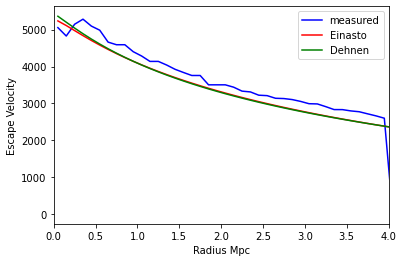

In [27]:
j=5
plt.plot(rad_0[j,:], m_edge_0[j,:], color = 'b', label = 'measured')
plt.plot(rad_0[j,:], vesc_M0_EIN[j,:], color = 'r', label = 'Einasto')
plt.plot(rad_0[j,:], vesc_M0_DEH[j,:], color = 'g', label = 'Dehnen')
print('Largest Halo Mass = ', M200_use[5], 'Solar Masses')
plt.xlim(0,4)
plt.xlabel('Radius Mpc')
plt.ylabel('Escape Velocity')
plt.legend()
plt.show()

In [28]:
perc_diff_M0 = []
median_perc_diff_M0 = []
median_high_M0 = []
median_low_M0 = []

perc_diff_M0_d = []
median_perc_diff_M0_d = []
median_high_M0_d = []
median_low_M0_d = []

for j in range(len(z_0)):
    pd_0 = (vesc_M0_EIN[j,:]-m_edge_0[j,:])/m_edge_0[j,:]
    perc_diff_M0.append(pd_0)
    pd_0_d = (vesc_M0_DEH[j,:]-m_edge_0[j,:])/m_edge_0[j,:]
    perc_diff_M0_d.append(pd_0_d)
    
perc_diff_arr_M0 = np.array(perc_diff_M0)
perc_diff_arr_M0_d = np.array(perc_diff_M0_d)

for m in range(80):
    median = np.percentile(perc_diff_arr_M0[:,m],50)
    median_perc_diff_M0.append(median)
    median_high = np.percentile(perc_diff_arr_M0[:,m],83.5)
    median_high_M0.append(median_high)
    median_low = np.percentile(perc_diff_arr_M0[:,m],16.5)
    median_low_M0.append(median_low)
    median_d = np.percentile(perc_diff_arr_M0_d[:,m],50)
    median_perc_diff_M0_d.append(median_d)
    median_high_d = np.percentile(perc_diff_arr_M0_d[:,m],83.5)
    median_high_M0_d.append(median_high_d)
    median_low_d = np.percentile(perc_diff_arr_M0_d[:,m],16.5)
    median_low_M0_d.append(median_low_d)

<ipython-input-28-a0dc44722bb9>:12: RuntimeWarning: divide by zero encountered in true_divide
  pd_0 = (vesc_M0_EIN[j,:]-m_edge_0[j,:])/m_edge_0[j,:]
<ipython-input-28-a0dc44722bb9>:14: RuntimeWarning: divide by zero encountered in true_divide
  pd_0_d = (vesc_M0_DEH[j,:]-m_edge_0[j,:])/m_edge_0[j,:]
/u/home/pvans/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:3942: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


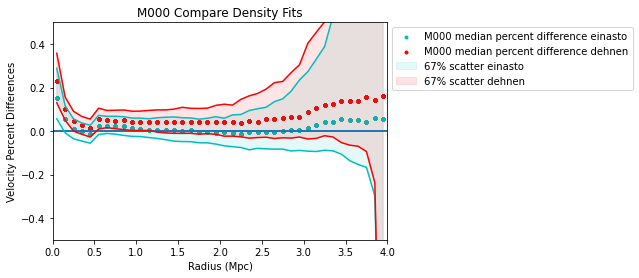

In [29]:
plt.title('M000 Compare Density Fits')
plt.xlabel('Radius (Mpc)')
plt.ylabel('Velocity Percent Differences')
for (j,k) in zip(range(len(z_0)), range(80)):
    if(j==0):
        plt.axhline(0)
        plt.scatter(rad_0[j,:], median_perc_diff_M0, color = 'c', marker = '.', label = 'M000 median percent difference einasto')
        plt.scatter(rad_0[j,:], median_perc_diff_M0_d, color = 'r', marker = '.', label = 'M000 median percent difference dehnen')
    else:
        plt.axhline(0)
        plt.scatter(rad_0[j,:], median_perc_diff_M0, color = 'c', marker = '.')
        plt.scatter(rad_0[j,:], median_perc_diff_M0_d, color = 'r', marker = '.')

plt.plot(rad_0[0], median_high_M0, color = 'c')
plt.plot(rad_0[0], median_low_M0, color = 'c')
plt.fill_between(rad_0[0], median_low_M0, median_high_M0, color = 'c', alpha = 0.1, label = '67% scatter einasto')

plt.plot(rad_0[0], median_high_M0_d, color = 'r')
plt.plot(rad_0[0], median_low_M0_d, color = 'r')
plt.fill_between(rad_0[0], median_low_M0_d, median_high_M0_d, color = 'r', alpha = 0.1, label = '67% scatter dehnen')

plt.xlim(0,4.0)
plt.ylim(-0.5,0.5)
plt.legend(loc = 'upper left', bbox_to_anchor=(1, 1))
plt.savefig('M0z0_comp.png', dpi=200)
plt.show()

In [18]:
z=0
h_0 = 0.7833
mass = cluster_list_10['m200crit']
hmass = mass/h_0
#print (len(hmass))
M200 = hmass*u.solMass
rho_crit = cosmo.critical_density(z)
rho_crit = rho_crit.to(u.solMass / u.Mpc**3)
print ('Astropys critical density: ', rho_crit)
print ('Internal critical density: ',rho_crit_z(z,cosmo_params,'Flatw0waCDM'))
R200crit =  (3*M200/(4*np.pi*200.* rho_crit))**(1./3.)
radius_array = np.linspace(0.3,2.0,100).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.
theta_array = radius_array /cosmo.angular_diameter_distance(z)
R200crit =  (3*M200/(4*np.pi*200.* rho_crit))**(1./3.)
#print ('Spherical R200 for a given M200: ', R200crit)
G_newton = astroc.G.to( u.Mpc *  u.km**2 / u.s**2 / u.solMass).value #Mpc km2/s^2 kg
#print ('Gravity (Mpc km2/s^2 kg), mass, cosmology: ', G_newton, M200, cosmo_params, cosmo.name)
#print ('q = ', q_z_function(z, cosmo_params,cosmo.name))
#print ('r_eq = ', r_eq(0.2,M200_orig,cosmo_params, cosmo.name))

NameError: name 'cluster_list_10' is not defined

In [57]:
z_10 = np.array((0.001))
z_10 = np.repeat(z_10,(114))
num_clus = len(z_10)
M200_orig = np.repeat(hmass,len(z_10))
M200_use = np.repeat(hmass,(1))
R200 =  ((3*M200)/(4*np.pi*200.* rho_crit))**(1./3.)
N = np.repeat(1000000,len(z_10))
rho_0_list = density_prof_10['rho_0']
h_list = density_prof_10['h']
n_list = density_prof_10['n']
rho_0 = np.repeat(rho_0_list, (1))
h = np.repeat(h_list, (1))
n = np.repeat(n_list, (1))

gamma_list = dehnen_prof_10['gamma']
mass0_list = dehnen_prof_10['mass0']
r_s_list = dehnen_prof_10['r_s']
gamma = np.repeat(gamma_list, (1))
mass_0 = np.repeat(mass0_list, (1))
r_s = np.repeat(r_s_list, (1))

radius_array = rad_10 #specify radius array for profiles. used in v_esc(r) funcs below.
radial_bins = 80
xdata = np.zeros((len(z_10),radial_bins))
for i in range(len(z_10)):
    xdata[i,:] = radius_array[i,:] /D_A(z_10[i], cosmo_params, cosmo.name).value
r_M10_DEH,vesc_M10_DEH = v_esc_dehnen(xdata,z_10,mass_0,r_s,gamma,N, cosmo_params, cosmo_name, num_clus)
r_M10_EIN,vesc_M10_EIN = v_esc_einasto(xdata,z_10,rho_0,h,n,N,cosmo_params, cosmo_name,num_clus)
r_M10_NFW,vesc_M10_NFW = v_esc_NFW_M200(xdata,z_10,M200_use,N,cosmo_params, cosmo_name, num_clus)

/nfs/Christoq1/pvans/MiraTitan/analysis_notebooks/escapevelocitycosmology/escape_functions_noastropy.py:77: RuntimeWarning: invalid value encountered in sqrt
  v_esc = (-2.*phi_dehnen(r,mass_0[i],r_s[i],gamma[i])+2.*phi_dehnen(req,mass_0[i],r_s[i],gamma[i]) - q_z*(H_z**2.)*(r**2. - req**2.)  )**0.5
/nfs/Christoq1/pvans/MiraTitan/analysis_notebooks/escapevelocitycosmology/escape_functions_noastropy.py:128: RuntimeWarning: invalid value encountered in sqrt
  v_esc =  (-2.*phi_einasto(r,rho_0[i],h[i],n[i])+2.*phi_einasto(req,rho_0[i],h[i],n[i]) - q_z*(H_z**2.)*(r**2. - req**2.)  )**0.5


In [58]:
print(r_M10_DEH,vesc_M10_DEH)

[[0.05 0.15 0.25 ... 7.75 7.85 7.95]
 [0.05 0.15 0.25 ... 7.75 7.85 7.95]
 [0.05 0.15 0.25 ... 7.75 7.85 7.95]
 ...
 [0.05 0.15 0.25 ... 7.75 7.85 7.95]
 [0.05 0.15 0.25 ... 7.75 7.85 7.95]
 [0.05 0.15 0.25 ... 7.75 7.85 7.95]] [[3146.38281591 2993.93193095 2855.03210472 ...  195.00798624
   178.25573867  161.31494399]
 [3285.84086855 3170.47439378 3043.8201765  ...  247.81046989
   231.47916092  215.16579074]
 [3636.39427569 3420.05635882 3263.16234657 ...  522.24851934
   504.52651048  486.88521085]
 ...
 [3431.46226577 3226.75240859 3060.93722613 ...  269.29877638
   252.67204479  236.04023993]
 [3100.86709587 2885.12495799 2727.91227775 ...  187.54210459
   169.42322693  150.75460222]
 [3681.35389865 3584.42463389 3476.08410725 ...  535.23609965
   517.54900848  499.99618379]]


In [61]:
print ((mass[108]))

1752720453140480.0


Largest Halo Mass =  2237610689570381.8 Solar Masses


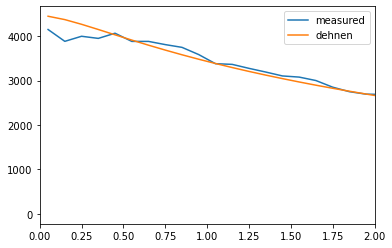

In [62]:
j=108
plt.plot(rad_10[j,:], m_edge_10[j,:], label = 'measured')
plt.plot(rad_10[j,:], vesc_M10_DEH[j,:], label = 'dehnen')
print('Largest Halo Mass = ', M200_use[108], 'Solar Masses')
plt.xlim(0,2)
plt.legend()
plt.show()

In [57]:
cosmo_name = 'FlatLambdaCDM'
cosmo = FlatLambdaCDM(H0=78.33, Om0=0.18553, name = cosmo_name)
cosmo_params = cosmology(cosmo)

In [58]:
z=0
h_0 = 0.7833
mass = cluster_list_10['m200crit']
hmass = mass/h_0
#print (len(hmass))
M200 = hmass*u.solMass
rho_crit = cosmo.critical_density(z)
rho_crit = rho_crit.to(u.solMass / u.Mpc**3)
print ('Astropys critical density: ', rho_crit)
print ('Internal critical density: ',rho_crit_z(z,cosmo_params,'FlatLambdaCDM'))
R200crit =  (3*M200/(4*np.pi*200.* rho_crit))**(1./3.)
radius_array = np.linspace(0.3,2.0,100).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.
theta_array = radius_array /cosmo.angular_diameter_distance(z)
R200crit =  (3*M200/(4*np.pi*200.* rho_crit))**(1./3.)
#print ('Spherical R200 for a given M200: ', R200crit)
G_newton = astroc.G.to( u.Mpc *  u.km**2 / u.s**2 / u.solMass).value #Mpc km2/s^2 kg
#print ('Gravity (Mpc km2/s^2 kg), mass, cosmology: ', G_newton, M200, cosmo_params, cosmo.name)
#print ('q = ', q_z_function(z, cosmo_params,cosmo.name))
#print ('r_eq = ', r_eq(0.2,M200_orig,cosmo_params, cosmo.name))

Astropys critical density:  170285064945.96158 solMass / Mpc3
Internal critical density:  170285064945.96152 solMass / Mpc3


/u/home/pvans/anaconda3/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [59]:
z_10 = np.array((0.001))
z_10 = np.repeat(z_10,(114))
num_clus = len(z_10)
M200_orig = np.repeat(hmass,len(z_10))
M200_use = np.repeat(hmass,(1))
R200 =  ((3*M200)/(4*np.pi*200.* rho_crit))**(1./3.)
N = np.repeat(1000000,len(z_10))
rho_0_list = density_prof_10['rho_0']
h_list = density_prof_10['h']
n_list = density_prof_10['n']
rho_0 = np.repeat(rho_0_list, (1))
h = np.repeat(h_list, (1))
n = np.repeat(n_list, (1))

gamma_list = dehnen_prof_10['gamma']
mass0_list = dehnen_prof_10['mass0']
r_s_list = dehnen_prof_10['r_s']
gamma = np.repeat(gamma_list, (1))
mass_0 = np.repeat(mass0_list, (1))
r_s = np.repeat(r_s_list, (1))

radius_array = rad_10 #specify radius array for profiles. used in v_esc(r) funcs below.
radial_bins = 80
xdata = np.zeros((len(z_10),radial_bins))
for i in range(len(z_10)):
    xdata[i,:] = radius_array[i,:] /D_A(z_10[i], cosmo_params, cosmo.name).value
r_M10_DEH_fl,vesc_M10_DEH_fl = v_esc_dehnen(xdata,z_10,mass_0,r_s,gamma,N, cosmo_params, cosmo_name, num_clus)
r_M10_EIN_fl,vesc_M10_EIN_fl = v_esc_einasto(xdata,z_10,rho_0,h,n,N,cosmo_params, cosmo_name,num_clus)
r_M10_NFW_fl,vesc_M10_NFW_fl = v_esc_NFW_M200(xdata,z_10,M200_use,N,cosmo_params, cosmo_name, num_clus)

In [60]:
perc_diff_M10 = []
median_perc_diff_M10 = []
median_high_M10 = []
median_low_M10 = []
perc_diff_M10_d = []
median_perc_diff_M10_d = []
median_high_M10_d = []
median_low_M10_d = []
perc_diff_M10_fl = []
perc_diff_M10_d_fl = []
median_perc_diff_M10_fl = []
median_perc_diff_M10_d_fl = []

for j in range(len(z_10)):
    pd_10 = (vesc_M10_EIN[j,:]-m_edge_10[j,:])/m_edge_10[j,:]
    perc_diff_M10.append(pd_10)
    pd_10_d = (vesc_M10_DEH[j,:]-m_edge_10[j,:])/m_edge_10[j,:]
    perc_diff_M10_d.append(pd_10_d)
    pd_10_fl = (vesc_M10_EIN_fl[j,:]-m_edge_10[j,:])/m_edge_10[j,:]
    perc_diff_M10_fl.append(pd_10_fl)
    pd_10_d_fl = (vesc_M10_DEH_fl[j,:]-m_edge_10[j,:])/m_edge_10[j,:]
    perc_diff_M10_d_fl.append(pd_10_d_fl)
    
perc_diff_arr_M10 = np.array(perc_diff_M10)
perc_diff_arr_M10_d = np.array(perc_diff_M10_d)
perc_diff_arr_M10_fl = np.array(perc_diff_M10_fl)
perc_diff_arr_M10_d_fl = np.array(perc_diff_M10_d_fl)
#print (perc_diff_arr_M0[0,0])

for m in range(80):
    median = np.percentile(perc_diff_arr_M10[:,m],50)
    median_perc_diff_M10.append(median)
    median_high = np.percentile(perc_diff_arr_M10[:,m],83.5)
    median_high_M10.append(median_high)
    median_low = np.percentile(perc_diff_arr_M10[:,m],16.5)
    median_low_M10.append(median_low)
    median_d = np.percentile(perc_diff_arr_M10_d[:,m],50)
    median_perc_diff_M10_d.append(median_d)
    median_high_d = np.percentile(perc_diff_arr_M10_d[:,m],83.5)
    median_high_M10_d.append(median_high_d)
    median_low_d = np.percentile(perc_diff_arr_M10_d[:,m],16.5)
    median_low_M10_d.append(median_low_d)
    median_fl = np.percentile(perc_diff_arr_M10_fl[:,m],50)
    median_perc_diff_M10_fl.append(median_fl)
    median_d_fl = np.percentile(perc_diff_arr_M10_d_fl[:,m],50)
    median_perc_diff_M10_d_fl.append(median_d_fl)

<ipython-input-60-ce2786704eb0>:15: RuntimeWarning: divide by zero encountered in true_divide
  pd_10 = (vesc_M10_EIN[j,:]-m_edge_10[j,:])/m_edge_10[j,:]
<ipython-input-60-ce2786704eb0>:17: RuntimeWarning: divide by zero encountered in true_divide
  pd_10_d = (vesc_M10_DEH[j,:]-m_edge_10[j,:])/m_edge_10[j,:]
<ipython-input-60-ce2786704eb0>:19: RuntimeWarning: divide by zero encountered in true_divide
  pd_10_fl = (vesc_M10_EIN_fl[j,:]-m_edge_10[j,:])/m_edge_10[j,:]
<ipython-input-60-ce2786704eb0>:21: RuntimeWarning: divide by zero encountered in true_divide
  pd_10_d_fl = (vesc_M10_DEH_fl[j,:]-m_edge_10[j,:])/m_edge_10[j,:]


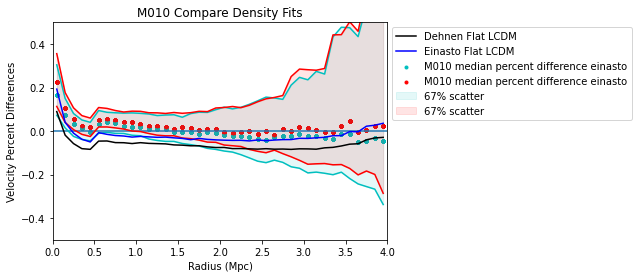

In [61]:
plt.title('M010 Compare Density Fits')
plt.xlabel('Radius (Mpc)')
plt.ylabel('Velocity Percent Differences')
for (j,k) in zip(range(len(z_10)), range(80)):
    if(j==0):
        plt.axhline(0)
        plt.scatter(rad_10[j,:], median_perc_diff_M10, color = 'c', marker = '.', label = 'M010 median percent difference einasto')
        plt.scatter(rad_10[j,:], median_perc_diff_M10_d, color = 'r', marker = '.', label = 'M010 median percent difference einasto')
    else:
        plt.scatter(rad_10[j,:], median_perc_diff_M10, color = 'c', marker = '.')  
        plt.scatter(rad_10[j,:], median_perc_diff_M10_d, color = 'r', marker = '.')

plt.plot(rad_10[0], median_high_M10, color = 'c')
plt.plot(rad_10[0], median_low_M10, color = 'c')
plt.fill_between(rad_10[0], median_low_M10, median_high_M10, color = 'c', alpha = 0.1, label = '67% scatter')

plt.plot(rad_10[0], median_high_M10_d, color = 'r')
plt.plot(rad_10[0], median_low_M10_d, color = 'r')
plt.fill_between(rad_10[0], median_low_M10_d, median_high_M10_d, color = 'r', alpha = 0.1, label = '67% scatter')

plt.plot(rad_1[0], median_perc_diff_M1_fl, color = 'black', label = 'Dehnen Flat LCDM')
plt.plot(rad_1[0], median_perc_diff_M1_fl_d, color = 'blue', label = 'Einasto Flat LCDM')

plt.xlim(0,4.0)
plt.ylim(-0.5,0.5)
plt.legend(loc = 'upper left', bbox_to_anchor=(1, 1))
plt.show()

## Now compare the models!

In [ ]:
perc_diff_M0 = []
perc_diff_M1 = []
perc_diff_M10 = []
mean_perc_diff_M0 = []
mean_perc_diff_M1 = []
mean_perc_diff_M10 = []
actual = []
for j in range(len(z_0)):
    pd_0 = (vesc_M0_EIN[j,:]-m_edge_0[j,:])/m_edge_0[j,:]
    perc_diff_M0.append(pd_0)
for k in range(len(z_1)):
    pd_1 = (vesc_M1_EIN[k,:]-m_edge_1[k,:])/m_edge_1[k,:]
    perc_diff_M1.append(pd_1)
for l in range(len(z_10)):
    pd_10 = (vesc_M10_EIN[l,:]-m_edge_10[l,:])/m_edge_10[l,:]
    perc_diff_M10.append(pd_10)

perc_diff_arr_M0 = np.array(perc_diff_M0)
perc_diff_arr_M1 = np.array(perc_diff_M1)
perc_diff_arr_M10 = np.array(perc_diff_M10)
#perc_diff_w0wa_arr = np.array(perc_diff_w0wa)

for m in range(60):
    mpd_0 = np.mean(perc_diff_arr_M0[:,m])
    mean_perc_diff_M0.append(mpd_0)
for n in range(80):
    mpd_1 = np.mean(perc_diff_arr_M1[:,n])
    mean_perc_diff_M1.append(mpd_1)
    mpd_10 = np.mean(perc_diff_arr_M10[:,n])
    mean_perc_diff_M10.append(mpd_10)

In [ ]:
#plt.scatter(rad_0[0,:], mean_perc_diff_M0[0], color = 'c', marker = '.', label = 'M000 mean')
print (rad_0[0,0])
print (mean_perc_diff_M0[0])

In [ ]:
plt.title('Compare Cosmologies')
plt.xlabel('Radius (Mpc)')
plt.ylabel('Velocity Percent Differences')
for (j,k) in zip(range(len(z_0)), range(60)):
    mean_edge = np.mean(vesc_M0_EIN[j,:])
    plt.plot(rad_0[j,:], (m_edge_0[j,:]-m_edge_0[j,:])/m_edge_0[j,:], color = 'black')
    plt.plot(rad_0[j,:], perc_diff_M0[j], color = 'c', alpha = 0.05)
    plt.scatter(rad_0[j,:], mean_perc_diff_M0, color = 'c', marker = '.')
for (j,k) in zip(range(len(z_1)), range(80)):
    mean_edge = np.mean(vesc_M1_EIN[j,:])
    #plt.plot(rad_1[j,:], (m_edge_1[j,:]-m_edge_1[j,:])/m_edge_1[j,:], color = 'black')
    plt.plot(rad_1[j,:], perc_diff_M1[j], color = 'g', alpha = 0.05)
    plt.scatter(rad_1[j,:], mean_perc_diff_M1, color = 'g', marker = '.')
for (j,k) in zip(range(len(z_10)), range(80)):
    mean_edge = np.mean(vesc_M10_EIN[j,:])
    #plt.plot(rad_10[j,:], (m_edge_10[j,:]-m_edge_10[j,:])/m_edge_10[j,:], color = 'black')
    plt.plot(rad_10[j,:], perc_diff_M10[j], color = 'r', alpha = 0.05)
    plt.scatter(rad_10[j,:], mean_perc_diff_M10, color = 'r', marker = '.')

plt.scatter(rad_0[0,0], mean_perc_diff_M0[0], color = 'c', marker = '.', label = 'M000 mean percent difference')
plt.scatter(rad_1[0,0], mean_perc_diff_M1[0], color = 'g', marker = '.', label = 'M001 mean percent difference')
plt.scatter(rad_10[0,0], mean_perc_diff_M10[0], color = 'r', marker = '.', label = 'M010 mean percent difference')
plt.plot(rad_0[0,:], perc_diff_M0[0], color = 'c', alpha = 0.2, label = 'M000 Inferred - Measured')
plt.plot(rad_1[0,:], perc_diff_M1[0], color = 'g', alpha = 0.2, label = 'M001 Inferred - Measured')
plt.plot(rad_10[0,:], perc_diff_M10[0], color = 'r', alpha = 0.2, label = 'M010 Inferred - Measured')

plt.rcParams['figure.figsize'] = [20, 20]
plt.xlim(0.5,2.0)
plt.ylim(-0.1,0.1)
plt.legend(loc = 'upper left', bbox_to_anchor=(1, 1))
plt.show()

## Compare Redshifts

In [ ]:
front_part_z02 = '/nfs/Christoq1/pvans/MiraTitan/halo/sort/M0z02/halopart/'
front_part_z04 = '/nfs/Christoq1/pvans/MiraTitan/halo/sort/M0z04/halopart/'
front_part_z06 = '/nfs/Christoq1/pvans/MiraTitan/halo/sort/M0z06/halopart/'
front_halo = '/nfs/Christoq1/pvans/MiraTitan/FOF/M000_good/'
front_ein_z02 = '/nfs/Christoq1/MiraTitanU_analysis/density_fits/results_pvans_M0/z02/'
front_ein_z04 = '/nfs/Christoq1/MiraTitanU_analysis/density_fits/results_pvans_M0/z04/'
front_ein_z06 = '/nfs/Christoq1/MiraTitanU_analysis/density_fits/results_pvans_M0/z06/'

In [ ]:
#z=0.2 files
rad_file_z02 = fits.open(front_ein_z02 + 'phi_ein/r_vescmax.fits')
rad_z02 = rad_file_z02[0].data
m_edge_file_z02 = fits.open(front_ein_z02 + 'phi_ein/v_at_vescmax5.fits')
m_edge_z02 = m_edge_file_z02[0].data
dens_fit_z02 = fits.open(front_ein_z02 + 'dens_ein/dens_fit.fits')
dt = [('HaloId',int), ('n',float), ('n_err',float),('rho_0',float),('rho_o_err',float),
          ('h',float),('h_err',float),('norm_ein',float)]
density_prof_z02 =  np.loadtxt(front_ein_z02 + 'dens_ein/ds_ein_concentrations.dat', dtype=dt,skiprows=0)

#z=0.4 files
rad_file_z04 = fits.open(front_ein_z04 + 'phi_ein/r_vescmax.fits')
rad_z04 = rad_file_z04[0].data
m_edge_file_z04 = fits.open(front_ein_z04 + 'phi_ein/v_at_vescmax5.fits')
m_edge_z04 = m_edge_file_z04[0].data
dens_fit_z04 = fits.open(front_ein_z04 + 'dens_ein/dens_fit.fits')
dt = [('HaloId',int), ('n',float), ('n_err',float),('rho_0',float),('rho_o_err',float),
          ('h',float),('h_err',float),('norm_ein',float)]
density_prof_z04 =  np.loadtxt(front_ein_z04 + 'dens_ein/ds_ein_concentrations.dat', dtype=dt,skiprows=0)

#z=0.6 files
rad_file_z06 = fits.open(front_ein_z06 + 'phi_ein/r_vescmax.fits')
rad_z06 = rad_file_z06[0].data
m_edge_file_z06 = fits.open(front_ein_z06 + 'phi_ein/v_at_vescmax5.fits')
m_edge_z06 = m_edge_file_z06[0].data
dens_fit_z06 = fits.open(front_ein_z06 + 'dens_ein/dens_fit.fits')
dt = [('HaloId',int), ('n',float), ('n_err',float),('rho_0',float),('rho_o_err',float),
          ('h',float),('h_err',float),('norm_ein',float)]
density_prof_z06 =  np.loadtxt(front_ein_z06 + 'dens_ein/ds_ein_concentrations.dat', dtype=dt,skiprows=0)

In [ ]:
print ('z=0.2 len', len(rad_z02))
print ('z=0.4 len', len(rad_z04))
print ('z=0.6 len', len(rad_z06))

In [ ]:
dt = [('HaloId', np.float64),('m200crit',np.float64),('px',float),('py',float),('pz',float),('vx',float),('vy',float),('vz',float)]
filename_z02 =  front_halo + 'z02_good.txt'
cluster_list_z02 =  np.loadtxt(filename_z02, dtype=dt,skiprows=0)
filename_z04 =  front_halo + 'z04_good.txt'
cluster_list_z04 =  np.loadtxt(filename_z04, dtype=dt,skiprows=0)
filename_z06 =  front_halo + 'z06_good.txt'
cluster_list_z06 =  np.loadtxt(filename_z06, dtype=dt,skiprows=0)

In [ ]:
print (len(cluster_list_z02['m200crit']))

In [ ]:
cosmo_name = 'FlatLambdaCDM'
cosmo = FlatLambdaCDM(H0=71,Om0=0.2314)
cosmo_params = cosmology(cosmo)

In [ ]:
z = 0.212304
h_0 = 0.71
mass = cluster_list_z02['m200crit']
hmass = mass/h_0
#print (hmass)
M200 = hmass*u.solMass
rho_crit = cosmo.critical_density(z)
rho_crit = rho_crit.to(u.solMass / u.Mpc**3)
print ('Astropys critical density: ', rho_crit)
print ('Internal critical density: ',rho_crit_z(z,cosmo_params,'Flatw0waCDM'))
R200crit =  (3*M200/(4*np.pi*200.* rho_crit))**(1./3.)
radius_array = np.linspace(0.3,2.0,100).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.
theta_array = radius_array /cosmo.angular_diameter_distance(z)
R200crit =  (3*M200/(4*np.pi*200.* rho_crit))**(1./3.)
#print ('Spherical R200 for a given M200: ', R200crit)
G_newton = astroc.G.to( u.Mpc *  u.km**2 / u.s**2 / u.solMass).value #Mpc km2/s^2 kg
#print ('Gravity (Mpc km2/s^2 kg), mass, cosmology: ', G_newton, M200, cosmo_params, cosmo.name)
#print ('q = ', q_z_function(z, cosmo_params,cosmo.name))
#print ('r_eq = ', r_eq(0.2,M200_orig,cosmo_params, cosmo.name))

In [ ]:
z = np.array((0.212304))
z = np.repeat(z,(126))
num_clus = len(z)
M200_orig = np.repeat(hmass,len(z))
M200_use = np.repeat(hmass,(1))
R200 =  ((3*M200)/(4*np.pi*200.* rho_crit))**(1./3.)
N = np.repeat(1000000,len(z))
rho_0_list = density_prof_z02['rho_0']
h_list = density_prof_z02['h']
n_list = density_prof_z02['n']
rho_0 = np.repeat(rho_0_list, (1))
h = np.repeat(h_list, (1))
n = np.repeat(n_list, (1))
radius_array = rad_z02 #specify radius array for profiles. used in v_esc(r) funcs below.
radial_bins = 80
xdata = np.zeros((len(z),radial_bins))
for i in range(len(z)):
    #print (radius_array[i,:])
    xdata[i,:] = radius_array[i,:] /D_A(z[i], cosmo_params, cosmo.name).value
    #print (xdata[i,:])
r_02_EIN,vesc_02_EIN = v_esc_einasto(xdata,z,rho_0,h,n,N,cosmo_params, cosmo_name,num_clus)
r_02_NFW,vesc_02_NFW = v_esc_NFW_M200(xdata,z,M200_use,N,cosmo_params, cosmo_name, num_clus)

### Do More Comparisons!

Read in halo and particle files. All of this comes directly from the Dark Skies Mass Estimation Notebook

In [ ]:
cosmo_name = 'Flatw0waCDM'
cosmo = Flatw0waCDM(H0=61.67, Om0=0.3362, w0 = -0.7, wa = 0.6722, name = cosmo_name)
cosmo_params = cosmology(cosmo)
#cosmo_name = 'FlatLambdaCDM'
#cosmo1 = FlatLambdaCDM(H0=61.67, Om0=0.3362, name = cosmo_name)
#cosmo_params = cosmology(cosmo1)

In [ ]:
z = 0.001
resolution = 1.05e10
a_halo = 1.0/(1+z)
Halo_v = [cluster_list['vx'][0],cluster_list['vy'][0],cluster_list['vz'][0]]
Halo_p = [cluster_list['px'][0]*a_halo,cluster_list['py'][0]*a_halo,cluster_list['pz'][0]*a_halo] #Note: this is the position in the Guo snapshot. These are zero for particle fits (I.e., do not use with particles)
txt = 'Halo ID: ', cluster_list['HaloId'][0]
print(txt)
txt = 'Halo px,py,pz = ',Halo_p
print(txt)
txt = 'Halo vx,vy,vz = ', Halo_v
print(txt)

In [ ]:
ppx = particles['pos_x']*a_halo # convert to physical coords
ppy = particles['pos_y']*a_halo
ppz = particles['pos_z']*a_halo
print(len(ppx))
ppx = ppx - Halo_p[0]
ppy = ppy - Halo_p[1]
ppz = ppz - Halo_p[2]

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax[0].plot(ppx,ppy,'.',ms=0.05)
ax[1].plot(ppy,ppz,'.',ms=0.05)

In [ ]:
ppx = ppx/h_0
ppy = ppy/h_0
ppz = ppz/h_0

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax[0].plot(ppx,ppy,'.',ms=0.05)
ax[1].plot(ppy,ppz,'.',ms=0.05)

In [ ]:
rpart = np.sqrt(ppx**2 + ppy**2 + ppz**2)
dens_radius_bookends = np.linspace(0,5,100)
density = []
cumul_density = []
dens_radius = []
print (resolution)
for i in range(99):
    #print (i)
    dens_radius = np.append(dens_radius, (dens_radius_bookends[i+1] + dens_radius_bookends[i])/2.0)
    volume = (4./3.)*np.pi*(dens_radius_bookends[i+1]**3.0 - dens_radius_bookends[i]**3.0 )
    count = len(np.where((rpart < dens_radius_bookends[i+1]))[0]) - len(np.where((rpart < dens_radius_bookends[i]))[0])
    #print ('count=',count)
    density = np.append(density,(count*resolution)/volume)
    #print('density=',density)
    count_cu = len(np.where((rpart < dens_radius_bookends[i+1]))[0])
    #print (count_cu)
    volume = 4./3.*np.pi*(dens_radius_bookends[i+1]**3.0)
    cumul_density = np.append(cumul_density, count_cu*resolution/volume)
    #print('cumulalitive density=', cumul_density)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
ax.plot(dens_radius, rho_einasto(dens_radius,density_prof['rho_0'][0],density_prof['h'][0],density_prof['n'][0]),'+',color='r',ms=10,label='Einasto')
ax.plot(dens_radius, density, label='data')
rho_crit = cosmo.critical_density(z)
rho_crit = rho_crit.to(u.solMass / u.Mpc**3)
print (200*rho_crit.value)
r200 = dens_radius[np.where(cumul_density < 200*rho_crit.value)[0][0]]
print(r200)
ax.set_yscale('log')
ax.set_title('Particle Density')
#ax.set_xlim(0,2*r200)
ax.legend()
ax.axvline(r200)
plt.show()
w = np.where(rpart < r200)[0]
mass200 = len(w)*resolution
text = 'Our inferred DM log10(M200_crit) = ', np.log10(mass200)
print(text)
text = 'MT reported log10(m200crit) = ', np.log10(cluster_list['m200crit'][0]/h_0)
print(text)

Used cumulative denisty as opposed to density used in DS example. Fits are probably closer once all halos are used. Only using one halo for now

In [ ]:
len_r = len(dens_radius)
len_r_interp = 9999
rho_crit = cosmo.critical_density(z)
rho_crit = rho_crit.to(u.solMass / u.Mpc**3)
r_denfit = np.linspace(np.min(dens_radius),np.max(dens_radius),len_r).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.
r_interp = np.linspace(np.min(dens_radius)+0.001,np.max(dens_radius)-0.001,len_r_interp).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.    
M200_fitted = []
R200_fitted = []
rho_r = []
for j in range(len_r):
            rho_r = np.append(rho_r,4*np.pi*integrate.quad(rho_einasto_int,0,r_denfit[j],args=(density_prof['rho_0'][0],density_prof['h'][0],density_prof['n'][0]))[0]/(4/3.*np.pi*(r_denfit[j]**3.0)))
log10_rho_r_func = interp1d(dens_radius, np.log10(rho_r), kind='quadratic')
log10_rho_r_interp = log10_rho_r_func(r_interp)
w = np.where(log10_rho_r_interp < np.log10(200*rho_crit.value))[0]
if (len(w) >0):
        R200_fitted = np.append(R200_fitted,r_interp[w[0]])
        M200_fitted = np.append(M200_fitted, 4*np.pi*integrate.quad(rho_einasto_int,0,r_interp[w[0]],args=(density_prof['rho_0'][0],density_prof['h'][0],density_prof['n'][0]))[0])
text = 'The Einasto inferred DM log10(M200) = ', np.log10(M200_fitted[0])
print(text)
text = 'The MT log10(m200crit) = ', np.log10(cluster_list['m200crit'][0]/h_0)
print(text)

Confirms Einasto will underestimate the mass